# Goal of the practical
1. Predict genes with ab-initio method `geneid` ([link](https://github.com/guigolab/geneid))
2. Build models from long-read RNA seq using `isoquant` ([link](https://github.com/ablab/IsoQuant))
3. Improve `geneid` prediction with long-read derived models
4. Visualise models in IGV
5. Evaluate models with `compann-nf` ([link](https://github.com/apollo994/compann-nf))
6. Check RNA support from an independent dataset

In [2]:
! rm -rf intermediate/ 
! rm -rf results/
! rm -rf bin/
! rm -rf compann/
! rm -rf LRsupport/
! rm -rf work/
! rm -rf compann-nf/
! rm geneid

rm: cannot remove 'geneid': No such file or directory


# 0. Data
geneome and reference : https://denovo.cnag.cat/ilHelHell_data
- selcet only chromosome 16
- index with `samtools faidx ilHelHell1.1_Chr16.soft_masked.fna`

reference = https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/963/853/865/GCA_963853865.1_ilHelHell1.1/

extract ilHelHell1.1_Chr16

a geneid parameter file obtained with https://github.com/fcamara7/GeneidTRAINerDocker

#### Inspect input data and prepare folders

In [223]:
! ls -lh data/

total 42M
-rw-r--r-- 1 fzanarello staff 756K May 27 11:31 ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff
-rw-r--r-- 1 fzanarello staff 359K May 26 20:36 ilHelHell1.1_Chr16_isoquant_wing.gtf
-rw-r--r-- 1 fzanarello staff 1.8M May 26 20:46 ilHelHell1.1_Chr16_REF.gff3
-rw-r--r-- 1 fzanarello staff  20M May 27 10:57 ilHelHell1.1_Chr16.hard_masked.fna
-rw-r--r-- 1 fzanarello staff   37 May 27 11:07 ilHelHell1.1_Chr16.hard_masked.fna.fai
-rw-r--r-- 1 fzanarello staff  20M May 27 17:23 ilHelHell1.1_Chr16.soft_masked.fna
-rw-r--r-- 1 fzanarello staff   37 May 27 17:23 ilHelHell1.1_Chr16.soft_masked.fna.fai
-rw-r--r-- 1 fzanarello staff 312K May 26 21:34 Lycaena_Helle.param


In [224]:
! ls -lh scripts/

total 8.0K
-rw-r--r-- 1 fzanarello staff 1.5K May  3 18:12 extract_features.sh
-rw-r--r-- 1 fzanarello staff 1.7K May 23 18:22 hard_mask.py


In [5]:
# prepare folders
! mkdir -p intermediate results bin LRsupport 

# 1. geneid
`geneid` is a probabilistic, *ab initio* gene finder that predicts the full structure of protein-coding genes directly from genomic DNA.

### Main features

1. **Signal-based probabilistic model**  
   Represents a gene as an ordered series of sequence “signals” (start/stop codons, donor/acceptor splice sites, coding potential). Each signal is scored with position-specific weight matrices and Markov models that capture local sequence preferences.

2. **Hierarchical, memory-efficient workflow**  
   Proceeds in stages—detecting signals, assembling exons, then genes—making it fast enough to scan large genomes on modest hardware. Exons are assembled into genes using a global dynamic-programming algorithm to find the highest-scoring path through exons into complete, biologically valid gene models while enforcing frame and splice-order constraints.

3. **Species-specific parameterisation**  
   Scoring matrices can be trained on well-annotated genomes of the same or a related species, adapting predictions to GC content, codon usage and splice-site motifs.

4. **Optional extrinsic hints**  
   Although fundamentally *ab initio*, `geneid` accepts external evidence (e.g. EST alignments, protein homology, RNA-seq junctions) as weighted constraints that can boost accuracy where data exist.

## Obtaining geneid
`geneid` precompiled binary MacOS can be obtained from [here](https://github.com/guigolab/geneid/releases/tag/v1.4.5) or can be compiled from source with the following steps

```
wget https://github.com/guigolab/geneid/archive/refs/heads/master.zip
unzip master.zip
cd geneid-master/ && make
```

Then you can test it with:
```
./geneid
```

#### Exercise 1.1
Download and install `geneid` in the current system. 

##### Solution

In [228]:
! wget https://github.com/guigolab/geneid/archive/refs/heads/master.zip
! unzip master.zip
! cd geneid-master/ && make
! mv geneid-master/bin/geneid bin/ 
! rm -rf master.zip geneid-master/

--2025-05-27 21:19:59--  https://github.com/guigolab/geneid/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/guigolab/geneid/zip/refs/heads/master [following]
--2025-05-27 21:19:59--  https://codeload.github.com/guigolab/geneid/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [              <=>   ]  15.92M  5.04MB/s    in 3.2s    

2025-05-27 21:20:03 (5.04 MB/s) - ‘master.zip’ saved [16696283]

Archive:  master.zip
5e01c2a3da3da15795f13fb34b0571b217c6f7ed
   creating: /Users/fzanarello/work/projects/summer_school/practicals/day2/fabio/geneid

In [229]:
! bin/geneid

Error: One filename is required (DNA sequence, Fasta format)
NAME
	geneid - a program to annotate genomic sequences
SYNOPSIS
	geneid	[-bdaefitnxszru]
		[-TDAZU]
		[-p gene_prefix]
		[-G] [-3] [-X] [-M] [-m]
		[-WCF] [-o]
		[-j lower_bound_coord]
		[-k upper_bound_coord]
		[-N numer_nt_mapped]
		[-O <gff_exons_file>]
		[-R <gff_annotation-file>]
		[-S <gff_homology_file>]
		[-P <parameter_file>]
		[-E exonweight]
		[-V evidence_exonweight]
		[-Bv] [-h]
		<locus_seq_in_fasta_format>
RELEASE
	geneid v 1.4



## Predict genes with geneid
The basic `geneid` command requires two arguments, the parameter file and the fasta.
```
geneid -P species.param genome.fa > genes
```

#### Exercise 1.2
Run `geneid` on the chromosome 16 of *Lycaena helle* and name the output `results/geneid_simple.gff3`, use `-3` for gff3 output.  
Then check the number of predicted genes with the `extract_features.sh` script

##### Solution

In [230]:
! time geneid -3P data/Lycaena_Helle.param data/ilHelHell1.1_Chr16.soft_masked.fna  > results/geneid_simple.gff3

geneid -3P data/Lycaena_Helle.param data/ilHelHell1.1_Chr16.soft_masked.fna >  14.19s user 0.50s system 97% cpu 15.023 total


In [231]:
! bash scripts/extract_features.sh results/geneid_simple.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	1245	13590369	10915.96	67.57
exon	5148	1820607	353.65	9.05
CDS	5148	1820607	353.65	9.05
gene	1245	13590369	10915.96	67.57


# 2. Build Transcitps models with IsoQuant
Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum

#### Isoquant command

```
isoquant.py --reference input/ref.fa \
    --index input/ref.fa.fai \
    --bam input/wing.bam \. # alternatively you can input fastq, the isoquant runs minimap2
    --data_type ont \
    --output results/wing_reffree \
    --prefix Lh_wing_isoquant_reffree \
    --threads 4 
```
#### Isoquant Output
```
wing_reffree/
├── isoquant.log
└── Lh_wing_isoquant_reffree
    ├── aux
    ├── ilHelHell1.1_Chr16_isoquant.gtf
    ├── ilHelHell1.1_Chr23_isoquant.gtf
    ├── Lh_wing_isoquant_reffree.corrected_reads.bed.gz
    ├── Lh_wing_isoquant_reffree.transcript_model_counts.tsv
    ├── Lh_wing_isoquant_reffree.transcript_model_reads.tsv.gz
    ├── Lh_wing_isoquant_reffree.transcript_models.gtf
    └── Lh_wing_isoquant_reffree.transcript_model_tpm.tsvesults/
```

### Selected models from chromosome 16 and introns added with agat
```
grep 'ilHelHell1.1_Chr16' Lh_wing_isoquant_reffree.transcript_models.gtf > data/ilHelHell1.1_Chr16_isoquant_wing.gtf
agat_sp_add_introns.pl --gff data/ilHelHell1.1_Chr16_isoquant_wing.gtf --out intermediate/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff
```

#### Check simple stats

In [427]:
! bash scripts/extract_features.sh data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	1403	453171	323.00	2.25
intron	1116	2954107	2647.05	14.69
transcript	287	3407278	11872.05	16.94
gene	236	2991122	12674.25	14.87


#### Exercise 2.1
Extract the number of features (gene, exon, transcript) from `data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff` using a combination of the `cut`, `sort`, `uniq` commands. 

##### Solution

In [428]:
! cut -f 3 data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff | sort | uniq -c

      1 ##gff-version 3
   1403 exon
    236 gene
   1116 intron
    287 transcript


# 3. Inform geneid with IsoQuant models 

We will inform geneid with exons and intronsLorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem IpsumWe will inform geneid with exons and intronsLorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem IpsumWe will inform geneid with exons and intronsLorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum

### Exons

In [235]:
! awk '$3 == "exon"' data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff > intermediate/exons.gff
! bedtools sort -i intermediate/exons.gff > intermediate/exons_sorted.gff

In [236]:
! head intermediate/exons_sorted.gff

ilHelHell1.1_Chr16	IsoQuant	exon	122316	122704	.	-	.	ID=ilHelHell1.1_Chr16.5807;Parent=transcript11832.ilHelHell1.1_Chr16.nnic;exon=2;exon_id=ilHelHell1.1_Chr16.5807;gene_id=novel_gene_ilHelHell1.1_Chr16_11833;transcript_id=transcript11832.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	exon	122774	122852	.	-	.	ID=ilHelHell1.1_Chr16.5806;Parent=transcript11832.ilHelHell1.1_Chr16.nnic;exon=1;exon_id=ilHelHell1.1_Chr16.5806;gene_id=novel_gene_ilHelHell1.1_Chr16_11833;transcript_id=transcript11832.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	exon	161875	162279	.	-	.	ID=ilHelHell1.1_Chr16.5810;Parent=transcript11828.ilHelHell1.1_Chr16.nnic;exon=3;exon_id=ilHelHell1.1_Chr16.5810;gene_id=novel_gene_ilHelHell1.1_Chr16_11836;transcript_id=transcript11828.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	exon	161875	162411	.	-	.	ID=ilHelHell1.1_Chr16.5811;Parent=transcript11835.ilHelHell1.1_Chr16.nnic;exon=2;exon_id=ilHelHell1.1_Chr16.5811;gene_id=novel_gene_ilHelHell1.1_Chr16_1183

In [237]:
! bedtools genomecov -strand + -bg -i intermediate/exons_sorted.gff -g data/ilHelHell1.1_Chr16.soft_masked.fna.fai > intermediate/exon_coverage_plus.bed
! bedtools genomecov -strand - -bg -i intermediate/exons_sorted.gff -g data/ilHelHell1.1_Chr16.soft_masked.fna.fai > intermediate/exon_coverage_minus.bed

In [238]:
! awk '{print $0 "\t+"}' intermediate/exon_coverage_plus.bed > intermediate/exon_coverage_plus_stranded.bed
! awk '{print $0 "\t-"}' intermediate/exon_coverage_minus.bed > intermediate/exon_coverage_minus_stranded.bed
! cat intermediate/exon_coverage_plus_stranded.bed intermediate/exon_coverage_minus_stranded.bed | bedtools sort > intermediate/exon_coverage_stranded.bed

In [239]:
! head -n 20 intermediate/exon_coverage_stranded.bed

ilHelHell1.1_Chr16	122315	122704	1	-
ilHelHell1.1_Chr16	122773	122852	1	-
ilHelHell1.1_Chr16	161874	162279	2	-
ilHelHell1.1_Chr16	162279	162344	1	-
ilHelHell1.1_Chr16	162344	162411	2	-
ilHelHell1.1_Chr16	163883	164151	2	-
ilHelHell1.1_Chr16	180413	180420	2	-
ilHelHell1.1_Chr16	180659	180681	2	-
ilHelHell1.1_Chr16	180838	180868	2	-
ilHelHell1.1_Chr16	180868	180928	1	-
ilHelHell1.1_Chr16	181071	181186	1	-
ilHelHell1.1_Chr16	442530	442788	1	+
ilHelHell1.1_Chr16	442876	443053	1	+
ilHelHell1.1_Chr16	443683	443839	1	+
ilHelHell1.1_Chr16	444937	445211	1	+
ilHelHell1.1_Chr16	445801	445914	1	+
ilHelHell1.1_Chr16	513395	513406	1	-
ilHelHell1.1_Chr16	513921	514720	1	-
ilHelHell1.1_Chr16	516711	517125	1	-
ilHelHell1.1_Chr16	521976	522201	1	-


In [240]:
! awk 'BEGIN{OFS="\t"} {print $1, "BEDTools", "exon", $2+1, $3, $4, $5, ".", "."}' intermediate/exon_coverage_stranded.bed > intermediate/exon_coverage_stranded.gff

In [241]:
! head -n 20 intermediate/exon_coverage_stranded.gff

ilHelHell1.1_Chr16	BEDTools	exon	122316	122704	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	122774	122852	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	161875	162279	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	162280	162344	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	162345	162411	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	163884	164151	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	180414	180420	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	180660	180681	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	180839	180868	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	180869	180928	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	181072	181186	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	442531	442788	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	exon	442877	443053	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	exon	443684	443839	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	exon	444938	445211	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	exon	445802	445914	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	exon	513396	513406	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	exon	513922	514720	1	-	.	.
ilHelHell1

In [242]:
! time geneid -3P data/Lycaena_Helle.param -S intermediate/exon_coverage_stranded.gff -u data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_S.gff3

geneid -3P data/Lycaena_Helle.param -S intermediate/exon_coverage_stranded.gf  111.04s user 3.68s system 99% cpu 1:55.82 total


In [243]:
! bash scripts/extract_features.sh results/geneid_S.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	1330	13508275	10156.60	67.17
exon	5272	2109894	400.21	10.49
UTR	396	283332	715.48	1.41
CDS	5272	1826562	346.46	9.08
gene	1330	13508275	10156.60	67.17


### Introns

In [262]:
! awk '$3 == "intron"' data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff > intermediate/introns.gff
! bedtools sort -i intermediate/introns.gff > intermediate/introns_sorted.gff

In [263]:
! head intermediate/introns.gff

ilHelHell1.1_Chr16	IsoQuant	intron	122705	122773	.	-	.	ID=intron_added-1;Parent=transcript11832.ilHelHell1.1_Chr16.nnic;exon=1;exon_id=ilHelHell1.1_Chr16.5806;gene_id=novel_gene_ilHelHell1.1_Chr16_11833;transcript_id=transcript11832.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	intron	162280	162344	.	-	.	ID=intron_added-2;Parent=transcript11828.ilHelHell1.1_Chr16.nnic;exon=1;exon_id=ilHelHell1.1_Chr16.5808;gene_id=novel_gene_ilHelHell1.1_Chr16_11836;transcript_id=transcript11828.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	intron	162412	163883	.	-	.	ID=intron_added-3;Parent=transcript11828.ilHelHell1.1_Chr16.nnic;exon=1;exon_id=ilHelHell1.1_Chr16.5808;gene_id=novel_gene_ilHelHell1.1_Chr16_11836;transcript_id=transcript11828.ilHelHell1.1_Chr16.nnic
ilHelHell1.1_Chr16	IsoQuant	intron	162412	163883	.	-	.	ID=intron_added-4;Parent=transcript11835.ilHelHell1.1_Chr16.nnic;exon=1;exon_id=ilHelHell1.1_Chr16.5808;gene_id=novel_gene_ilHelHell1.1_Chr16_11836;transcript_id=transcript11

In [264]:
! bedtools genomecov -strand + -bg -i intermediate/introns_sorted.gff -g data/ilHelHell1.1_Chr16.soft_masked.fna.fai > intermediate/introns_coverage_plus.bed
! bedtools genomecov -strand - -bg -i intermediate/introns_sorted.gff -g data/ilHelHell1.1_Chr16.soft_masked.fna.fai > intermediate/introns_coverage_minus.bed
! awk '{print $0 "\t+"}' intermediate/introns_coverage_plus.bed > intermediate/introns_coverage_plus_stranded.bed
! awk '{print $0 "\t-"}' intermediate/introns_coverage_minus.bed > intermediate/introns_coverage_minus_stranded.bed
! cat intermediate/introns_coverage_plus_stranded.bed intermediate/introns_coverage_minus_stranded.bed | bedtools sort > intermediate/introns_coverage_stranded.bed

In [265]:
! head intermediate/introns_coverage_stranded.bed

ilHelHell1.1_Chr16	122704	122773	1	-
ilHelHell1.1_Chr16	162279	162344	1	-
ilHelHell1.1_Chr16	162411	163883	2	-
ilHelHell1.1_Chr16	180420	180659	2	-
ilHelHell1.1_Chr16	180681	180838	2	-
ilHelHell1.1_Chr16	180868	181071	1	-
ilHelHell1.1_Chr16	442788	442876	1	+
ilHelHell1.1_Chr16	443053	443683	1	+
ilHelHell1.1_Chr16	443839	444937	1	+
ilHelHell1.1_Chr16	445211	445801	1	+


In [266]:
! awk 'BEGIN{OFS="\t"} {print $1, "BEDTools", "Intron", $2+1, $3, $4, $5, ".", "."}' intermediate/introns_coverage_stranded.bed > intermediate/introns_coverage_stranded.gff

In [267]:
! head intermediate/introns_coverage_stranded.gff

ilHelHell1.1_Chr16	BEDTools	Intron	122705	122773	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	162280	162344	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	162412	163883	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	180421	180659	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	180682	180838	2	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	180869	181071	1	-	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	442789	442876	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	443054	443683	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	443840	444937	1	+	.	.
ilHelHell1.1_Chr16	BEDTools	Intron	445212	445801	1	+	.	.


In [268]:
! time geneid -3P data/Lycaena_Helle.param -R intermediate/introns_coverage_stranded.gff data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_R.gff3

geneid -3P data/Lycaena_Helle.param -R   > results/geneid_R.gff3  14.82s user 0.30s system 99% cpu 15.148 total


In [269]:
! bash scripts/extract_features.sh results/geneid_R.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	1261	13492474	10699.82	67.09
exon	5218	1829925	350.69	9.10
CDS	5218	1829925	350.69	9.10
gene	1261	13492474	10699.82	67.09


### Combine exons and introns

In [270]:
! time geneid -3P data/Lycaena_Helle.param -R intermediate/introns_coverage_stranded.gff -S intermediate/exon_coverage_stranded.gff -u data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_RS.gff3

geneid -3P data/Lycaena_Helle.param -R  -S  -u  > results/geneid_RS.gff3  115.31s user 5.13s system 98% cpu 2:02.28 total


In [271]:
! bash scripts/extract_features.sh results/geneid_RS.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	1324	13513657	10206.69	67.19
exon	5281	2036315	385.59	10.12
UTR	443	222374	501.97	1.11
CDS	5197	1813941	349.04	9.02
gene	1324	13513657	10206.69	67.19


## Summary of genid runs
```
time geneid -3P data/Lycaena_Helle.param data/ilHelHell1.1_Chr16.soft_masked.fna  > results/geneid_simple.gff3
time geneid -3P data/Lycaena_Helle.param -S intermediate/exon_coverage_stranded.gff -u data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_S.gff3
time geneid -3P data/Lycaena_Helle.param -R intermediate/introns_coverage_stranded.gff data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_R.gff3
time geneid -3P data/Lycaena_Helle.param -R intermediate/introns_coverage_stranded.gff -S intermediate/exon_coverage_stranded.gff -u data/ilHelHell1.1_Chr16.soft_masked.fna > results/geneid_RS.gff3
```

# 4. Inspect results

In [272]:
import igv_notebook
igv_notebook.init()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [273]:
gv_browser_rescue= igv_notebook.Browser(
    {
        "reference": {
            "id": "ilHelHell1.1_Chr16",
            "name": "Lycaena helle",
            "fastaPath": "data/ilHelHell1.1_Chr16.soft_masked.fna",
            "indexPath": "data/ilHelHell1.1_Chr16.soft_masked.fna.fai"
        },
        "locus": "ilHelHell1.1_Chr16.1:10-20000",
        "tracks": [
            {
                "name": "REFERENCE",
                "path": "data/ilHelHell1.1_Chr16_REF.gff3",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            },
            {
                "name": "LR models",
                "path": "data/ilHelHell1.1_Chr16_isoquant_wing_withIntron.gff",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            },
            {
                "name": "geneid SIMPLE",
                "path": "results/geneid_simple.gff3",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            },
            {
                "name": "geneid exon",
                "path": "results/geneid_S.gff3",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            },
            {
                "name": "geneid intron",
                "path": "results/geneid_R.gff3",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            },
            {
                "name": "geneid exon/intron",
                "path": "results/geneid_RS.gff3",
                "format": "gff",
                "type": "annotation",
                "displayMode": "SQUISHED"
            }
        ]
    }
)

<IPython.core.display.Javascript object>

# 5. Compare results

In [274]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

### Get the pipeline and prepare input
Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum

- clone the repository
- link all gffs to compare in a single folder
- create output folder

In [425]:
! git clone -b summerschool_freeze git@github.com:apollo994/compann-nf.git

Cloning into 'compann-nf'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 626 (delta 109), reused 212 (delta 77), pack-reused 364 (from 1)
Receiving objects: 100% (626/626), 11.28 MiB | 8.28 MiB/s, done.
Resolving deltas: 100% (309/309), done.


#### Exercise 5.1
Check the features count and name in the reference annotation `data/ilHelHell1.1_Chr16_REF.gff3`. Make sure the feature names are matching those from geneid annotations. 

##### Solution

In [275]:
! bash scripts/extract_features.sh data/ilHelHell1.1_Chr16_REF.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
exon	4294	1385843	322.74	6.89
CDS	4184	1033017	246.90	5.14
transcript	832	12004171	14428.09	59.69
gene	743	10173814	13692.89	50.59


In [276]:
! awk 'BEGIN{OFS=FS="\t"} {$3 = ($3 == "transcript" ? "mRNA" : $3); print}' data/ilHelHell1.1_Chr16_REF.gff3 > results/ilHelHell1.1_Chr16_REF.gff3

In [277]:
! bash scripts/extract_features.sh results/ilHelHell1.1_Chr16_REF.gff3 data/ilHelHell1.1_Chr16.soft_masked.fna

Feature	Features_Count	Total_Feature_Length	Average_Feature_Length	Genome_Percentage
mRNA	832	12004171	14428.09	59.69
exon	4294	1385843	322.74	6.89
CDS	4184	1033017	246.90	5.14
gene	743	10173814	13692.89	50.59


#### set up for `compann-nf`

In [ ]:
# folder for input and output
! mkdir -p compann/input
! mkdir -p compann/output

# link gffs to compare in the input, make sure the path is relative using -r
! ln -rs results/geneid*gff3 compann/input
! ln -rs results/ilHelHell1.1_Chr16_REF.gff3 compann/input/CNAC_ref.gff3

# check files in the input folder
! ls -l compann/input/

### Run Pipeline

```
nextflow run compann-nf/main.nf \
        --gff_folder compann/input \
        --outputFolder compann/output \
        --ref $(realpath data/ilHelHell1.1_Chr16.soft_masked.fna) \
        --lineage lepidoptera_odb12 \
        -resume
```

#### Inspect results

In [285]:
! ls compann/output/*

compann/output/CNAC_ref_longest_isoform.gff
compann/output/geneid_R_longest_isoform.gff
compann/output/geneid_RS_longest_isoform.gff
compann/output/geneid_S_longest_isoform.gff
compann/output/geneid_simple_longest_isoform.gff

compann/output/BUSCO:

compann/output/gffcompare:
ALL
combined_gffcompare_ALL.tsv
combined_gffcompare_from0_to200.tsv
combined_gffcompare_from1000_to5000.tsv
combined_gffcompare_from200_to500.tsv
combined_gffcompare_from500_to1000.tsv
combined_gffcompare_from5000_to10000000.tsv
from0_to200
from1000_to5000
from200_to500
from500_to1000
from5000_to10000000

compann/output/summary_stat:
combined_ministats.csv	extended  mini


### Busco

#### Prepare dataframe for plotting

In [417]:
busco_df = pd.read_csv('compann/output/BUSCO/summary/combined_BUSCO_results.csv')
plt_busco_df = busco_df.transpose()
plt_busco_df.index = plt_busco_df.index.map(lambda a : a.replace('BUSCO_','').replace('_transcripts',''))
plt_busco_df.columns = plt_busco_df.iloc[0]
plt_busco_df = plt_busco_df.drop('metric')
plt_busco_df = plt_busco_df[['Complete percentage','Fragmented percentage','Missing percentage']].apply(pd.to_numeric)
plt_busco_df = plt_busco_df.loc[['CNAC_ref',
                                 'geneid_simple',  
                                 'geneid_R',
                                 'geneid_S',
                                 'geneid_RS' ]]

In [418]:
plt_busco_df

metric,Complete percentage,Fragmented percentage,Missing percentage
CNAC_ref,4.5,0.1,95.5
geneid_simple,3.4,0.9,95.7
geneid_R,3.9,0.6,95.6
geneid_S,3.8,0.7,95.5
geneid_RS,3.8,0.6,95.6


#### Visualise busco completnessm

(0.0, 5.0)

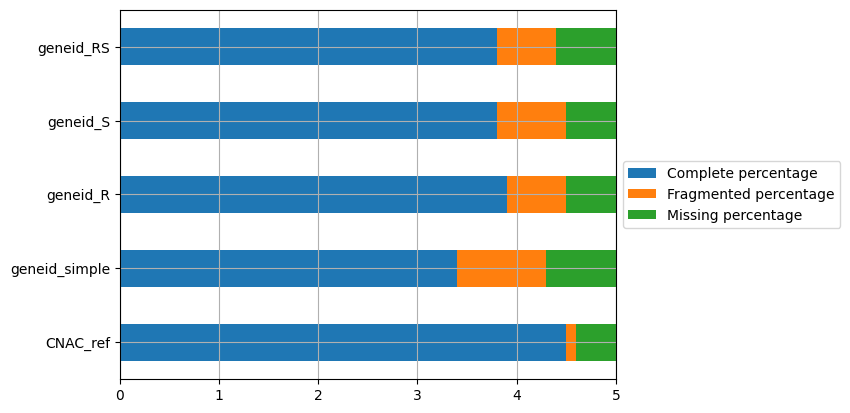

In [310]:
from matplotlib import pyplot as plt 

plt_busco_df.plot(kind='barh', stacked = 'True')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0,5)

#### Questions
- What are the limit of BUSCO completness
- Could you suggest a strategy to complement for these limits

### Summary statistics

#### Prepare dataframe for plotting

In [287]:
summary_df = pd.read_csv('compann/output/summary_stat/combined_ministats.csv')
summary_df['Label'] = summary_df['Sample'].map(lambda x : x.replace('_longest_isoform','').split('_')[-1])
summary_df = summary_df.melt(id_vars=['Sample', 'Segment', 'Type','Label'],
                value_vars=['Number','Size total (kb)','Size mean (bp)', 'Genome percentage (%)'])

summary_df

,Sample,Segment,Type,Label,variable,value
0,geneid_simple_longest_isoform,ALL,mRNA,simple,Number,1245.00
1,geneid_simple_longest_isoform,ALL,gene,simple,Number,1245.00
2,geneid_simple_longest_isoform,ALL,exon,simple,Number,5148.00
3,geneid_simple_longest_isoform,ALL,intron,simple,Number,3903.00
4,geneid_simple_longest_isoform,ALL,CDS,simple,Number,5148.00
...,...,...,...,...,...,...
663,geneid_RS_longest_isoform,from1000_to5000,gene,RS,Genome percentage (%),5.88
664,geneid_RS_longest_isoform,from1000_to5000,exon,RS,Genome percentage (%),3.17
665,geneid_RS_longest_isoform,from1000_to5000,intron,RS,Genome percentage (%),2.71
666,geneid_RS_longest_isoform,from1000_to5000,UTR,RS,Genome percentage (%),0.35


#### Inspect main summary statistics

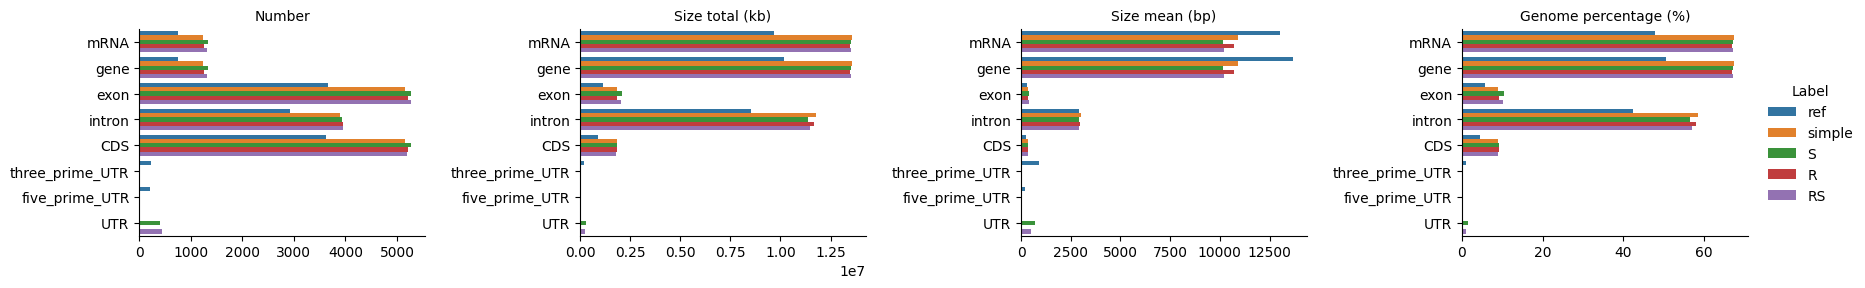

In [382]:
g = sns.catplot(data = summary_df[summary_df['Segment'] == 'ALL'],
           y = 'Type',
           x = 'value',
           col = 'variable',
           hue = 'Label',
           hue_order = ['ref', 'simple', 'S', 'R', 'RS'],
           kind = 'bar', 
           sharey = False,
           sharex = False,
           aspect=1.5, 
           height=3
           )

g.set_titles("{col_name}")
g.set_ylabels("")
g.set_xlabels("")

#### Summary statistics can be segmented on gene length segmentation 

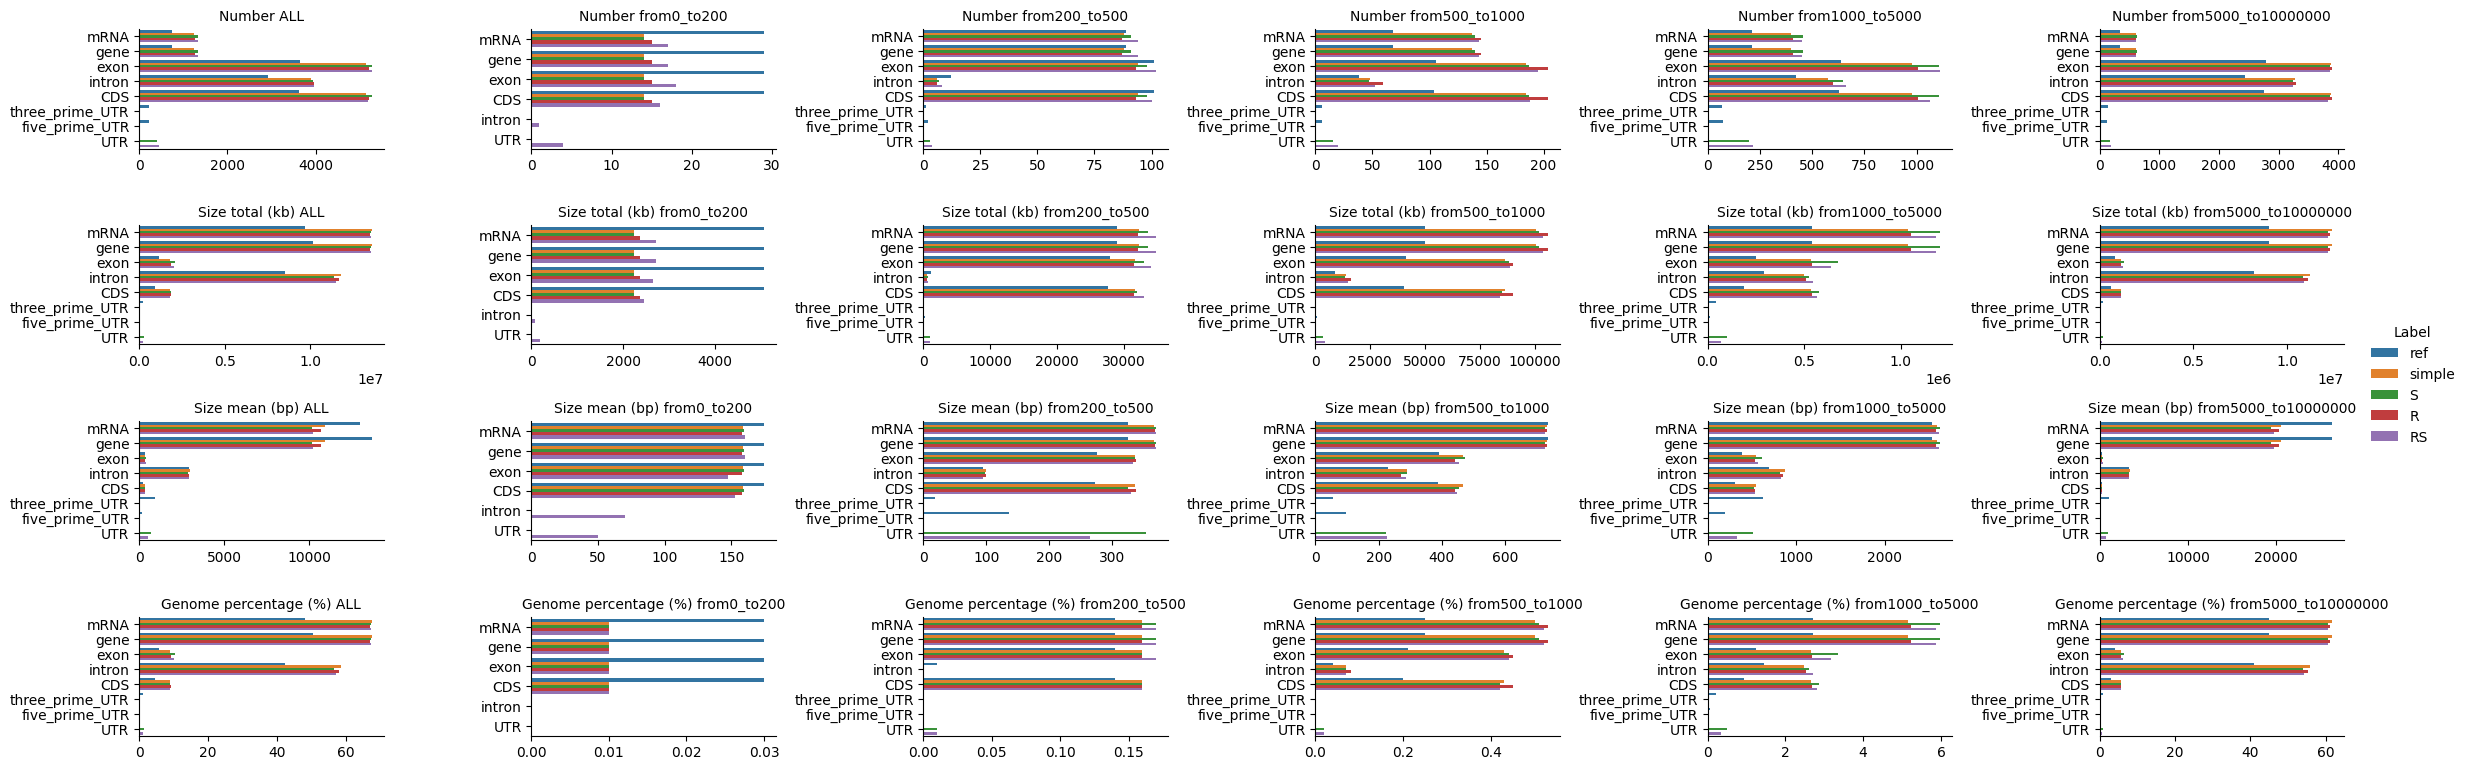

In [380]:
# reporting all available features

g = sns.catplot(data = summary_df,
           y = 'Type',
           x = 'value',
           row = 'variable',
           col = 'Segment',
           col_order = ['ALL', 'from0_to200', 'from200_to500', 'from500_to1000', 'from1000_to5000', 'from5000_to10000000'],
           hue = 'Label',
           hue_order = ['ref', 'simple', 'S', 'R', 'RS'],
           kind = 'bar', 
           sharey = False,
           sharex = False,
           aspect=2, 
           height=2
           )

g.set_titles("{row_name} {col_name}")
g.set_ylabels("")
g.set_xlabels("")

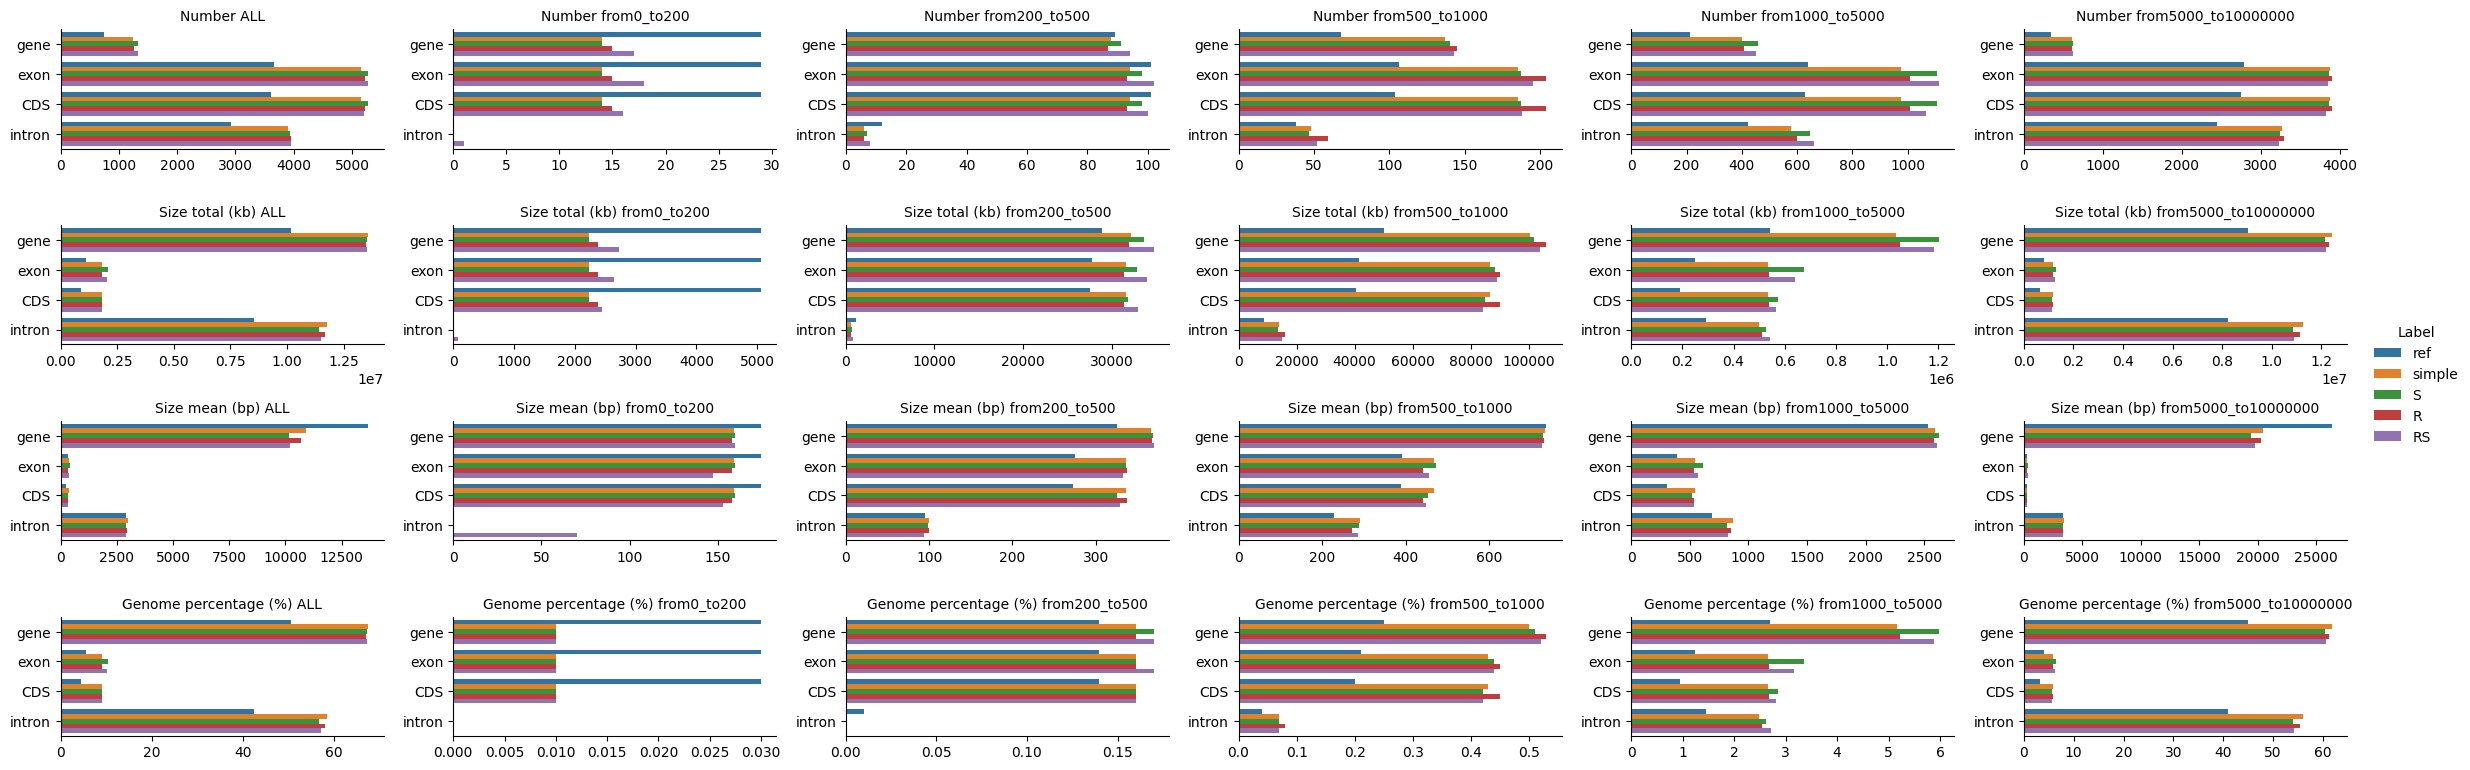

In [381]:
# focusing only on some features

g = sns.catplot(data = summary_df,
           y = 'Type',
           order = ['gene', 'exon','CDS','intron'],
           x = 'value',
           row = 'variable',
           col = 'Segment',
           col_order = ['ALL', 'from0_to200', 'from200_to500', 'from500_to1000', 'from1000_to5000', 'from5000_to10000000'],
           hue = 'Label',
           hue_order = ['ref', 'simple', 'S', 'R', 'RS'],
           kind = 'bar', 
           sharey = False,
           sharex = False,
           aspect=2, 
           height=2
           )

g.set_titles("{row_name} {col_name}")
g.set_ylabels("")
g.set_xlabels("")

#### Check features length distributions

In [395]:
files = ! ls compann/output/summary_stat/extended/*/with_isoforms/*.tsv

In [407]:
dist_df = pd.DataFrame()

for f in files:
    ft = f.split('/')[-1].split('_')[-1].replace('.tsv','')
    sample = f.split('/')[4].replace('_agat_extended.txt_raw_data','')
    tmp = pd.read_csv(f, sep = '\t')
    tmp['ft'] = ft
    tmp['sample'] = sample
    dist_df = pd.concat([dist_df, tmp])

dist_df = dist_df.reset_index(drop=True)

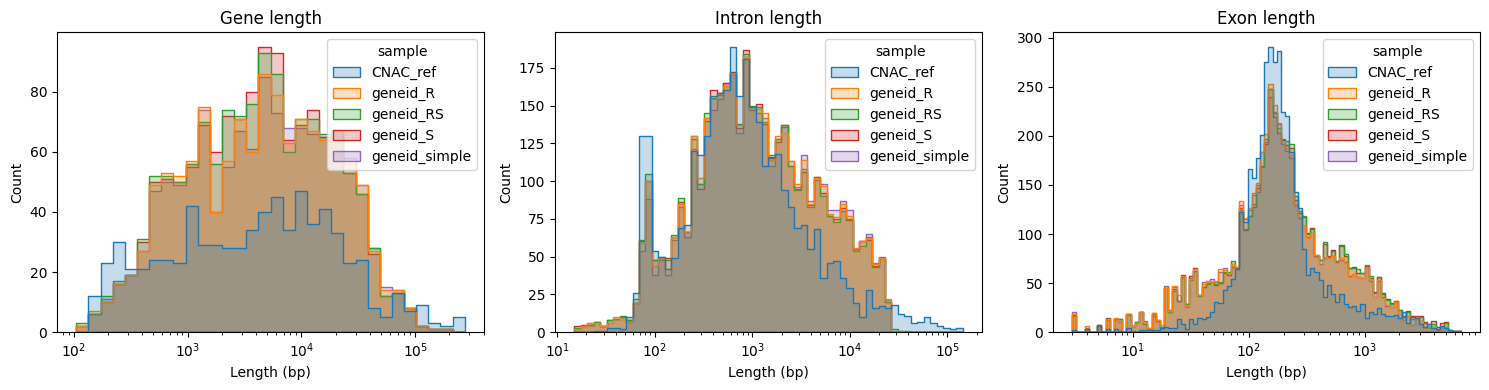

In [416]:
features = ["gene", "intron", "exon"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, feat in zip(axes, features):
    sns.histplot(data=dist_df.query("ft == @feat"),
                 x="Size(bp)",
                 hue="sample",
                 element="step",
                 ax=ax,
                 log_scale=True,
                )

    ax.set_title(f"{feat.capitalize()} length")
    ax.set_xlabel("Length (bp)")

plt.tight_layout()
plt.show()

### gff compare

#### Prepare dataframe for plotting

In [422]:
all_gffcompare = ! ls compann/output/gffcompare/*tsv

# import from file
gffcompare_df = pd.DataFrame()
for f in all_gffcompare:
    segment = f.split('/')[-1].replace('combined_gffcompare_','').replace('.tsv','')
    tmp = pd.read_csv(f)
    tmp['segment'] = segment
    gffcompare_df = pd.concat([gffcompare_df, tmp])

# shape dataframe for plotting
gffcompare_df['ref'] = gffcompare_df['ref'].map(lambda x : x.split('_longest_isoform')[0].replace('geneid_',''))
gffcompare_df['query'] = gffcompare_df['query'].map(lambda x : x.split('_longest_isoform')[0].replace('geneid_',''))
gffcompare_df = gffcompare_df[(gffcompare_df['ref'] == 'CNAC_ref') & (gffcompare_df['query'] != 'CNAC_ref')]
metrics = ['base_level_Se', 'base_level_Pr','base_level_F1',
           'exon_level_Se', 'exon_level_Pr', 'exon_level_F1',
           'intron_level_Se', 'intron_level_Pr', 'intron_level_F1',
           'intronChain_level_Se', 'intronChain_level_Pr', 'intronChain_level_F1',
           'transcript_level_Se', 'transcript_level_Pr', 'transcript_level_F1',
           'locus_level_Se', 'locus_level_Pr','locus_level_F1']
gffcompare_df = gffcompare_df[gffcompare_df['variable'].isin(metrics)]
gffcompare_df['value'] = pd.to_numeric(gffcompare_df['value'])
gffcompare_df['measure'] = gffcompare_df['variable'].map(lambda x : x.split('_')[-1])
gffcompare_df['level'] = gffcompare_df['variable'].map(lambda x : x.split('_')[0])
gffcompare_df = gffcompare_df.reset_index(drop=True)

# reshape for scatterplot
pivoted = gffcompare_df.pivot_table(
    index=['comparison', 'ref', 'query', 'level', 'segment'],
    columns='measure',
    values='value'
).reset_index()

In [423]:
gffcompare_df

,comparison,ref,query,variable,value,segment,measure,level
0,CNAC_ref_VS_geneid_R,CNAC_ref,R,base_level_Se,62.6,ALL,Se,base
1,CNAC_ref_VS_geneid_simple,CNAC_ref,simple,base_level_Se,61.5,ALL,Se,base
2,CNAC_ref_VS_geneid_RS,CNAC_ref,RS,base_level_Se,71.5,ALL,Se,base
3,CNAC_ref_VS_geneid_S,CNAC_ref,S,base_level_Se,71.7,ALL,Se,base
4,CNAC_ref_VS_geneid_R,CNAC_ref,R,base_level_Pr,41.6,ALL,Pr,base
...,...,...,...,...,...,...,...,...
427,CNAC_ref_longest_isoform_from5000_to10000000_V...,CNAC_ref,RS,transcript_level_F1,7.8,from5000_to10000000,F1,transcript
428,CNAC_ref_longest_isoform_from5000_to10000000_V...,CNAC_ref,R,locus_level_F1,7.4,from5000_to10000000,F1,locus
429,CNAC_ref_longest_isoform_from5000_to10000000_V...,CNAC_ref,simple,locus_level_F1,4.8,from5000_to10000000,F1,locus
430,CNAC_ref_longest_isoform_from5000_to10000000_V...,CNAC_ref,S,locus_level_F1,8.3,from5000_to10000000,F1,locus


In [424]:
pivoted

measure,comparison,ref,query,level,segment,F1,Pr,Se
0,CNAC_ref_VS_geneid_R,CNAC_ref,R,base,ALL,50.0,41.6,62.6
1,CNAC_ref_VS_geneid_R,CNAC_ref,R,exon,ALL,47.0,40.7,55.6
2,CNAC_ref_VS_geneid_R,CNAC_ref,R,intron,ALL,53.6,47.2,62.0
3,CNAC_ref_VS_geneid_R,CNAC_ref,R,intronChain,ALL,12.6,10.6,15.5
4,CNAC_ref_VS_geneid_R,CNAC_ref,R,locus,ALL,10.3,8.2,13.9
...,...,...,...,...,...,...,...,...
131,CNAC_ref_longest_isoform_from500_to1000_VS_gen...,CNAC_ref,simple,exon,from500_to1000,17.7,14.1,23.6
132,CNAC_ref_longest_isoform_from500_to1000_VS_gen...,CNAC_ref,simple,intron,from500_to1000,6.9,6.2,7.9
133,CNAC_ref_longest_isoform_from500_to1000_VS_gen...,CNAC_ref,simple,intronChain,from500_to1000,5.3,4.4,6.7
134,CNAC_ref_longest_isoform_from500_to1000_VS_gen...,CNAC_ref,simple,locus,from500_to1000,2.0,1.5,2.9


#### Check F1 score across levels

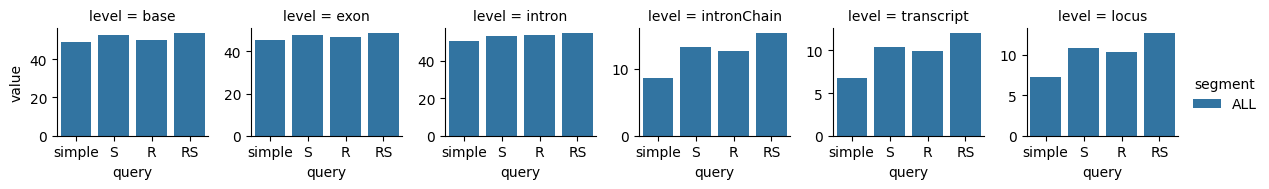

In [372]:
sns.catplot(data = gffcompare_df[(gffcompare_df['segment'] == 'ALL') & (gffcompare_df['measure'] == 'F1')],
           x = 'query',
           order = ['simple','S','R','RS'],
           y = 'value',
           col = 'level',
           kind = 'bar', 
           hue = 'segment',
           sharey = False,
           aspect=1, 
           height=2
           )

#### A scatter plot can help in comparing Precision and Sensitivity at different feature level

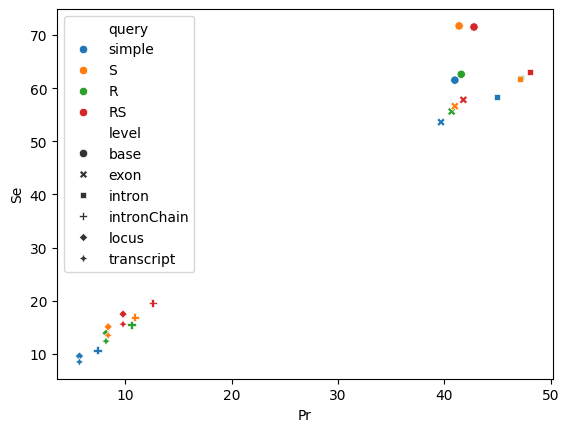

In [361]:
g = sns.scatterplot(
    data = pivoted[pivoted['segment'] == 'ALL'],
    x='Pr',
    y='Se',
    hue='query',
    hue_order = ['simple','S','R','RS'],
    style = 'level'
    
)

#### Precision ad sensitivity can also be segmented over gene length

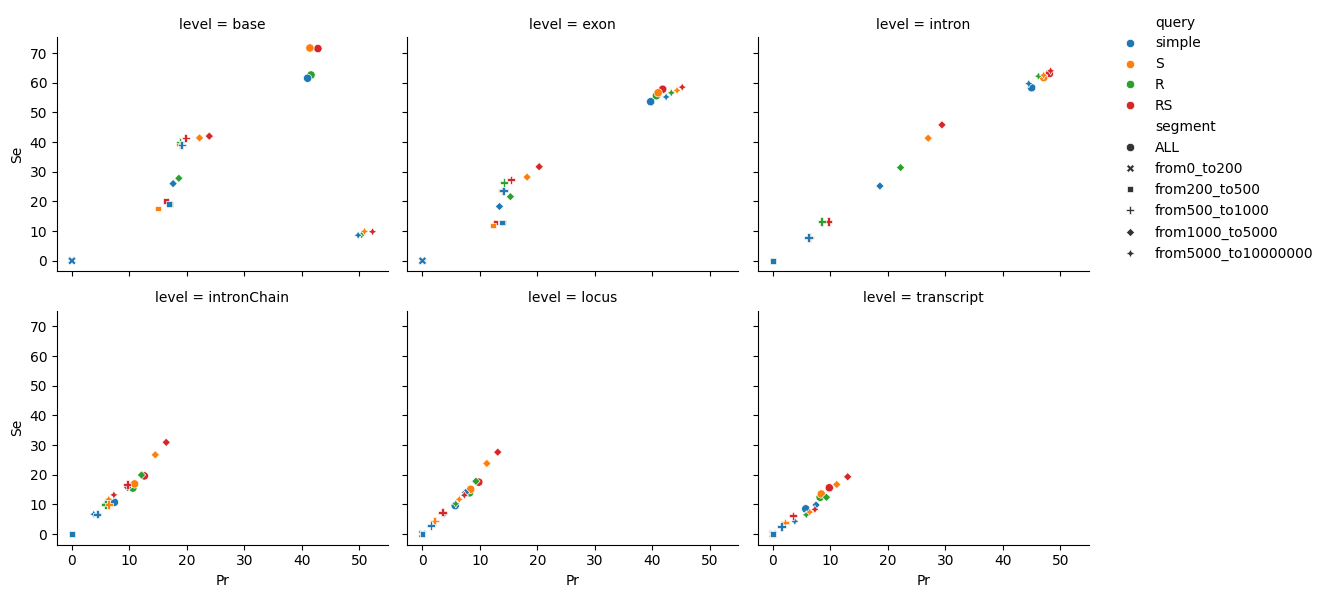

In [358]:
g = sns.FacetGrid(
    pivoted,
    col='level',
    col_wrap=3,        
    height=3,
    aspect=1
)

g.map_dataframe(
    sns.scatterplot,
    x='Pr',
    y='Se',
    hue='query',
    hue_order = ['simple','S','R','RS'],
    style = 'segment',
    style_order =  ['ALL', 'from0_to200', 'from200_to500', 'from500_to1000', 'from1000_to5000', 'from5000_to10000000'],
)

g.add_legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

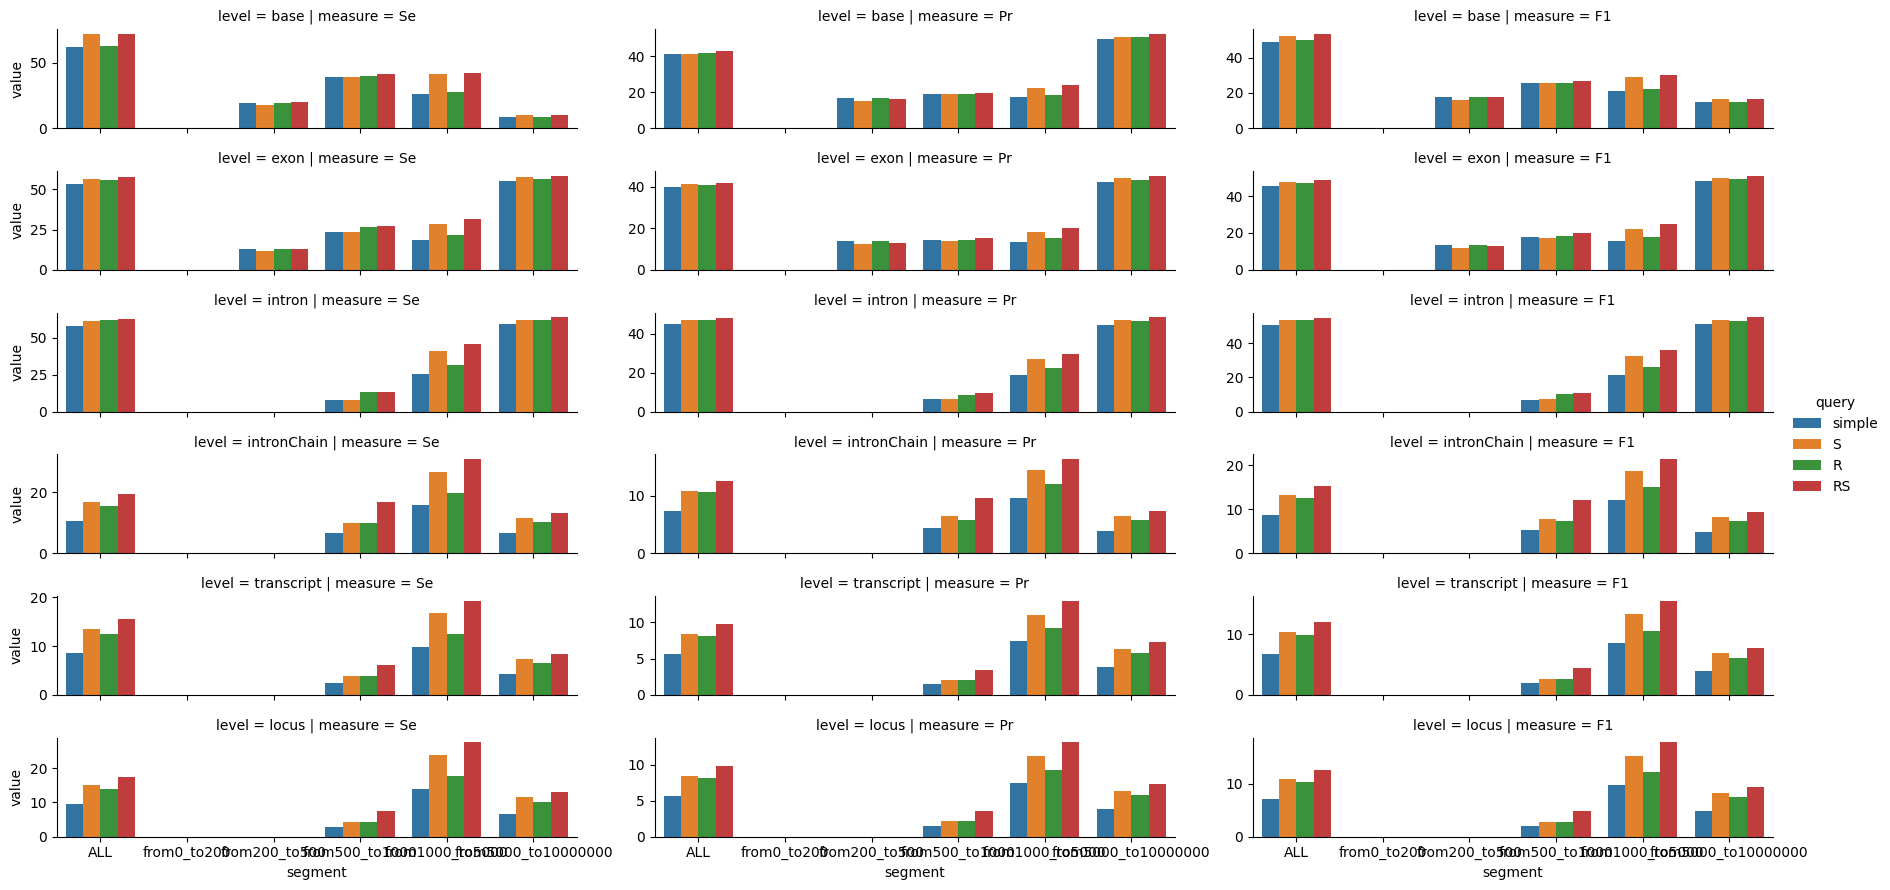

In [303]:
sns.catplot(data = gffcompare_df,
           hue = 'query',
           hue_order = ['simple','S','R','RS'],
           y = 'value',
           col = 'measure',
           row = 'level', 
           kind = 'bar', 
           x = 'segment',
           order = ['ALL', 'from0_to200', 'from200_to500', 'from500_to1000', 'from1000_to5000', 'from5000_to10000000'],
           sharey = False,
           # sharex = False,
           aspect=4, 
           height=1.5
           )

# 6. Check RNA support from independent dataset
An alternative to validate newely gene obtained models is to measure how many of them are supported (overlap) with RNA-seq reads.
Here we will use another LR RNAseq dataset obtained from the same species but from leg tissue instead of wings.
This apporach can also be used to inform on the dataset potential in discovering new gene loci as all reads non overlapping any genes migth correspond to un annotated loci. 
The steps to follow are: 
- map reads (already done and filtered for chromosome 16)
- measure how many models are supported by the reads
- measure how many reads support models 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### check model coverage

In [3]:
# measure coverage
! bedtools coverage -a data/ilHelHell1.1_Chr16_isoquant_wing.gtf -b data/ilHelHell1.1_Chr16.leg.bam > LRsupport/ref.support.csv
print ('RefSeq DONE')

geneid_res = ! find results/ -name 'geneid*'

for f in geneid_res:
    sample_name = f.split('/')[-1].replace('.gff3','')
    ! bedtools coverage -a $f -b data/ilHelHell1.1_Chr16.leg.bam > LRsupport/$sample_name'.support.csv'
    print (sample_name, 'DONE')


RefSeq DONE
geneid_S DONE
geneid_RS DONE
geneid_simple DONE
geneid_R DONE


In [4]:
support_df = pd.DataFrame()

support_results = ! find LRsupport/ -name '*.support.csv'
for f in support_results:
    sample_name = f.split('/')[-1].split('.')[0]      # store sample name
    tmp = pd.read_csv(f, sep = '\t', header=None)     
    tmp['sample'] = sample_name
    tmp = tmp.rename(columns= {2:'feature',           # rename only relevant columns 
                            9:'depth',
                            12:'breath'})
    tmp = tmp[tmp['feature'].isin(['exon','gene'])]
    support_df = pd.concat([support_df, tmp])
    
support_df = support_df.reset_index(drop=True)
support_df = support_df.melt(                         # reshape table
            id_vars=['sample','feature'],
            value_vars=['depth','breath'])

In [5]:
support_df

,sample,feature,variable,value
0,geneid_simple,gene,depth,0.0
1,geneid_simple,exon,depth,0.0
2,geneid_simple,exon,depth,0.0
3,geneid_simple,gene,depth,0.0
4,geneid_simple,exon,depth,0.0
...,...,...,...,...
55431,ref,exon,breath,1.0
55432,ref,exon,breath,1.0
55433,ref,exon,breath,1.0
55434,ref,exon,breath,1.0


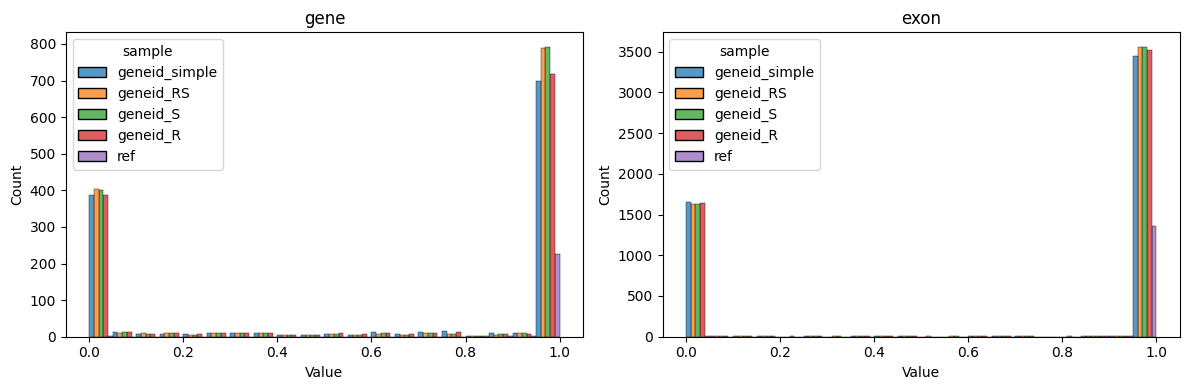

In [7]:
# Filter for the 'breath' variable
breath_df = support_df[support_df['variable'] == 'breath']

# Get unique features to create subplots
features = breath_df['feature'].unique()
n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(6 * n_features, 4), sharex=False)
if n_features == 1:
    axes = [axes]

# Plot each histogram in its own subplot
for ax, feature in zip(axes, features):
    data = breath_df[breath_df['feature'] == feature]
    sns.histplot(data=data,
                 x="value",
                 hue="sample",
                 bins=20,
                 multiple="dodge",
                 kde=False,
                 ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

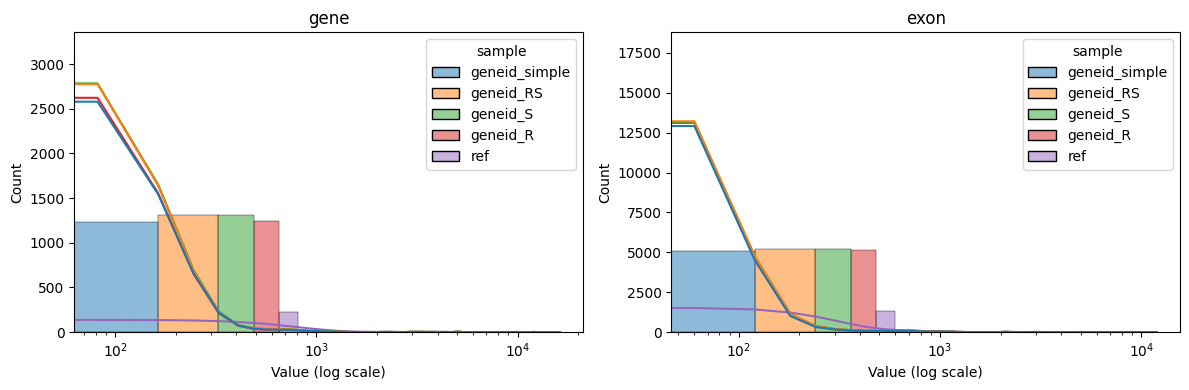

In [9]:
# Filter for the 'depth' variable
depth_df = support_df[support_df['variable'] == 'depth']

# Get unique features
features = depth_df['feature'].unique()
n_features = len(features)

fig, axes = plt.subplots(1, n_features, figsize=(6 * n_features, 4), sharex=False)
if n_features == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    data = depth_df[depth_df['feature'] == feature]

    sns.histplot(
        data=data,
        x="value",
        hue="sample",
        bins=20,
        kde=True,
        multiple="dodge",
        ax=ax
    )

    ax.set_title(feature)
    ax.set_xlabel("Value (log scale)")
    ax.set_ylabel("Count")
    ax.set_xscale("log")  

plt.tight_layout()
plt.show()

#### Check unassigned reads of RS genid and reference

In [37]:
samples = { 
    'isoquant_wing' : {'file' : 'data/ilHelHell1.1_Chr16_isoquant_wing.gtf'},
    'geneid_simple' : {'file' : 'results/geneid_simple.gff3'},
    'geneid_RS' : {'file' : 'results/geneid_RS.gff3'},
    'ref' : {'file' : 'results/ilHelHell1.1_Chr16_REF.gff3'}
    }

In [38]:
# obtain intervals
for sample in samples:
    f = samples[sample]['file']
    out = f'intermediate/{sample}.gene.bed'
    samples[sample]['interval'] = out
    awk_command = """awk 'BEGIN { OFS="\\t" } $3 == "gene" { print $1, $4-1, $5 }'"""
    !{awk_command} {f} > {out}

In [39]:
# count reads in intervals
for sample in samples:
    interval = samples[sample]['interval']
    total = ! ! samtools view -c data/ilHelHell1.1_Chr16.leg.bam
    assigned = ! samtools view -c -L $interval data/ilHelHell1.1_Chr16.leg.bam
    samples[sample]['tot'] = int(total[0])
    samples[sample]['assigned'] = int(assigned[0])
    samples[sample]['% unassigned'] = round(100 - int(assigned[0])*100/int(total[0]),2)

In [40]:
samples

{'isoquant_wing': {'file': 'data/ilHelHell1.1_Chr16_isoquant_wing.gtf',
  'interval': 'intermediate/isoquant_wing.gene.bed',
  'tot': 73171,
  'assigned': 62047,
  '% unassigned': 15.2},
 'geneid_simple': {'file': 'results/geneid_simple.gff3',
  'interval': 'intermediate/geneid_simple.gene.bed',
  'tot': 73171,
  'assigned': 65397,
  '% unassigned': 10.62},
 'geneid_RS': {'file': 'results/geneid_RS.gff3',
  'interval': 'intermediate/geneid_RS.gene.bed',
  'tot': 73171,
  'assigned': 70527,
  '% unassigned': 3.61},
 'ref': {'file': 'results/ilHelHell1.1_Chr16_REF.gff3',
  'interval': 'intermediate/ref.gene.bed',
  'tot': 73171,
  'assigned': 71039,
  '% unassigned': 2.91}}

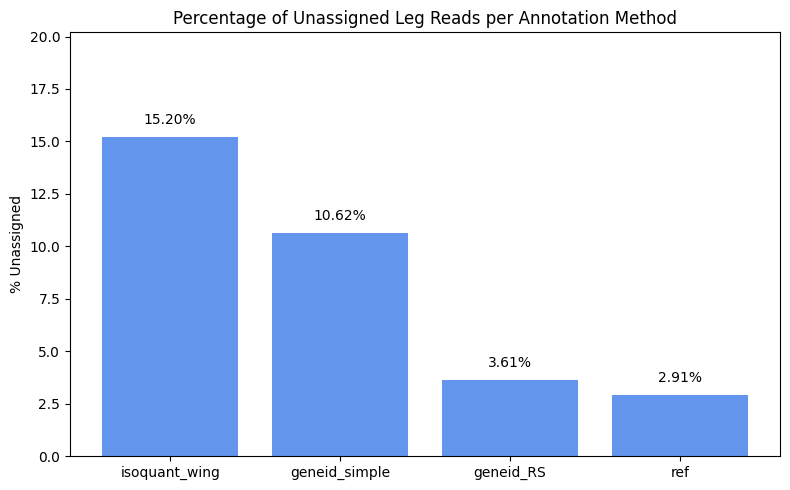

In [42]:
unassigned_df = pd.DataFrame.from_dict(samples)#.melt(value_vars=samples.keys())
df = unassigned_df.T

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df.index, df['% unassigned'], color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f"{height:.2f}%", ha='center', va='bottom', fontsize=10)

ax.set_ylabel('% Unassigned')
ax.set_title('Percentage of Unassigned Leg Reads per Annotation Method')
ax.set_ylim(0, max(df['% unassigned']) + 5)

plt.tight_layout()
plt.show()

#### Questions
- What aspect of the data could bias this analysis
- What types of element could be still be annotated even if reads are overlapping know gene models